In [1]:
import os
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from pysph.solver.utils import iter_output, load
from scipy.signal import argrelextrema
pi, sin, cos = np.pi, np.sin, np.cos

OUTPUT_DIR = ''

In [6]:
def ramp(t_star):
    if t_star>=0.0 and t_star<0.1:
        return t_star*10.
    elif t_star>=0.1 and t_star<0.9:
        return 1.
    elif t_star>=0.9 and t_star<=1.:
        return (1.-t_star)*10.
    else:
        return 0.
    
def get_sub_fldrs(path):
    folders = []
    for folder in os.listdir(path):
        if os.path.isdir(
            os.path.join(path, folder)
        ):
            # Get absolute path of folder
            abs_path = os.path.abspath(os.path.join(path, folder))
            folders.append(abs_path)
    folders = [fldr for fldr in folders if os.path.basename(fldr).startswith('c0_')]
    return folders

def get_opts_from_fldr(fname):
    fname = os.path.basename(fname)
    opts = {}
    expected_keys = ['c0', 'dtmul', 'nx', 're']
    kwrds = fname.split('_')
    kwrds.remove('tsph')
    # Get the values of the expected keys
    for key in expected_keys:
        try:
            idx = kwrds.index(key)
            opts[key] = kwrds[idx+1]
            kwrds.remove(key)
            kwrds.remove(opts[key])
        except ValueError:
            pass
    opts['integrator'] = kwrds[0]
    return opts

def get_master_dict(main_dict):
    """
    Given a list of dictionaries, return a dictionary of the form:
        {'key1': [val1, val2, ...], 'key2': [val1, val2, ...], ...}
    """
    master_dict = {}
    for d in main_dict:
        for key, val in d.items():
            if key not in master_dict:
                master_dict[key] = [val]
            else:
                master_dict[key].append(val)
    # Remove duplicate values
    for key, val in master_dict.items():
        master_dict[key] = list(set(val))
        
    return master_dict
    
def get_results_file(path):
    for file in os.listdir(path):
        if file.endswith('results.npz'):
            return os.path.join(path, file)

def select_subfolder(subfolders, **kwargs):
    """
    Given a list of subfolders, and a dictionary of the form:
        {'key1': val1, 'key2': val2, ...}
    return a list of subfolders that match the criteria.
    Example:
        select_subfolder(folders, re='100')
    """
    if len(kwargs) == 0:
        return subfolders

    # Make a copy of subfolders
    selected = subfolders.copy()
    # Loop over all keys in kwargs
    for key, val in kwargs.items():
        if len(selected) == 0:
            return []
        # Remove folders that don't match the criteria
        for fldr in subfolders:
            # tf = os.path.basename(fldr)
            opts = get_opts_from_fldr(fldr)
            # print(tf)
            # print(opts)
            if key not in opts.keys() and (fldr in selected):
                selected.remove(fldr)
            else:
                if opts[key] != val and (fldr in selected):
                    selected.remove(fldr)
    return selected

In [3]:
def get_cola_ke_data(re):
    if re == 1e6:
        x = [0.1275794476976334, 0.26829240537367094, 0.48780470523266317, 0.6735457664228459, 0.8255158036551533, 0.9043151458381081, 0.9437148169295854, 0.9943715675773322, 1.1744839816339134, 1.3264538041552867, 2.063790045915218, 2.7842401315634095, 3.4709196226755936, 4.168855549211246, 4.697936355957521, 5.401501144337708, 5.964352975041857]
        y = [0.0009063363330951701, 0.017220517101224297, 0.07462232912850364, 0.16042296002871512, 0.24864047245082715, 0.3012084522857153, 0.3229606971514757, 0.3386706921134246, 0.3374622283029443, 0.3368579963977042, 0.3338368483962684, 0.33081570039483266, 0.32900299315434717, 0.3277945523933969, 0.3277945523933969, 0.3253776362972013, 0.32658610010768163]
    elif re == 1e5:
        x = [0.14446517438750506, 0.3527201799792935, 0.5497183207257461, 0.7523451086058007, 0.893058066281838, 0.9606001141975891, 0.9887427057327965, 1.0675420479157514, 1.2138834380144565, 1.5009382152110675, 1.951219679774388, 2.6041277175068283, 3.842401745055959, 5.181989273900583, 5.91369665381598]
        y = [0.0009063363330951701, 0.032326257108403034, 0.09939575656999483, 0.19969788404737993, 0.29335347209188833, 0.32658610010768163, 0.33444108030150854, 0.3350452891572187, 0.33081570039483266, 0.32839878429863706, 0.3223564882957655, 0.31631419229289404, 0.30845921209906707, 0.30543806409763136, 0.30362536838191084]
    elif re == 1e4:
        x = [0.15009360681017303, 0.3414633151339578, 0.5778609122609538, 0.8255158036551533, 0.8986864987045062, 0.6735457664228459, 0.9549716817749213, 0.9943715675773322, 1.0731704803384192, 1.365853689957698, 2.1031895022957614, 2.8517826089010283, 3.926829519661582, 5.013133724689339, 5.958724972041058]
        y = [0.0021147770940455057, 0.030513595966977725, 0.10362536838191092, 0.22145014043790534, 0.2758308044637489, 0.1477341245929669, 0.292145008281408, 0.29879151313998964, 0.29637462009332405, 0.27280965646231314, 0.22507553186934628, 0.18821751242211202, 0.16706947641206177, 0.15679756859727417, 0.151963736404883]
    else:
        x, y = None, None
        return x, y
    return x, y

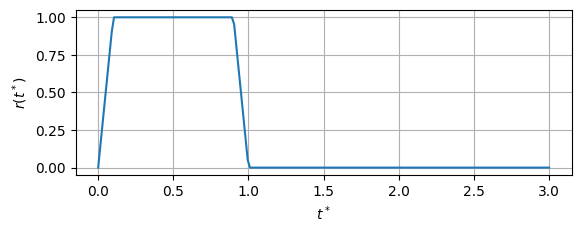

In [11]:
# Plot ramp
t_star = np.linspace(0, 3, 200)
r = np.array([ramp(t) for t in t_star])
plt.plot(t_star, r)
plt.grid()
plt.xlabel(r'$t^*$')
plt.ylabel(r'$r(t^*)$')
# Equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

In [4]:
def plotter(
    parent_dir, plot_type, ylim=None, exact=False,
    plt_ramp=False, ramp_a=1.3, save_fig=False, 
    plot_method='plot', plot_ke_max=False, plot_ke_expected=False,
    **kwargs
):
    plot_types = ['decay', 'l1', 'linf', 'p_l1', 'ke']
    if plot_type not in plot_types:
        raise ValueError(
            f'Invalid plot type: {plot_type}. Valid types are: {plot_types}'
        )
    subfolders = get_sub_fldrs(parent_dir)
    subfolders = select_subfolder(subfolders, **kwargs)

    if plot_method == 'semilogy':
        plotter_func = plt.semilogy
    elif plot_method == 'plot':
        plotter_func = plt.plot
    else:
        raise ValueError(
            f'Invalid plot method: {plot_method}. Valid methods are: plot, semilogy'
        )

    # Get maximum time
    t_sim_max = []
    for folder in subfolders:
        results_file = get_results_file(folder)
        if results_file:
            data = np.load(results_file)
            t_sim_max.append(data['t'][-1])
    t_sim_max_id = np.argmax(t_sim_max)
    
    plot_exact = exact
    plt.figure(figsize=(8, 6))
    for folder in subfolders:
        results_file = get_results_file(folder)
        if results_file:
            data = np.load(results_file)
            t = data['t']
            plt_label = os.path.basename(folder)
            
            if plot_type == 'decay':
                if plot_exact:
                    _data = get_results_file(subfolders[t_sim_max_id])
                    _data = np.load(_data)
                    _t, decay_ex = _data['t'], _data['decay_ex']
                    plotter_func(_t, decay_ex, 'k--', label='Exact')
                    plot_exact = False
                plotter_func(t, data['decay'], label=plt_label)
            elif plot_type == 'l1':
                plotter_func(t, data['l1'], label=plt_label)
            elif plot_type == 'linf':
                plotter_func(t, data['linf'], label=plt_label)
            elif plot_type == 'p_l1':
                plotter_func(t, data['p_l1'], label=plt_label)
            elif plot_type == 'ke':
                if plot_exact:
                    _data = get_results_file(subfolders[t_sim_max_id])
                    _data = np.load(_data)
                    _t, ke_ex = _data['t'], _data['ke_ex']
                    plotter_func(_t, ke_ex, 'k--', label='Exact')
                    plot_exact = False
                if plot_ke_expected:
                    re = int(get_opts_from_fldr(folder)['re'])
                    x, y = get_cola_ke_data(re)
                    if x is not None:
                        plotter_func(
                            x, y, 'k--', label='Colagrossi et al. (2019)'
                        )
                    plot_ke_expected = False
                plotter_func(t, data['ke'], label=plt_label)
        else:
            print(f'No results file found in {folder}')
    
    plot_exact = exact
    plot_ramp = plt_ramp
    for folder in subfolders:
        results_file = get_results_file(folder)
        if results_file:
            data = np.load(results_file)
            t = data['t']

            if plot_ramp:
                _t = np.linspace(0, t[-1], 700)
                f = [ramp(i) for i in _t]
                f = np.array(f)*ramp_a
                label = 'External force'
                if ramp_a == 1.3:
                    label += ' (Exact)'
                else:
                    label += ' (Trendline)'
                plotter_func(_t, f, 'k--', label=label)
                plot_ramp = False

            if plot_type == 'ke' and plot_ke_max:
                if plot_exact:
                    maxima = argrelextrema(data['ke_ex'], np.greater)
                    if len(maxima[0]) > 0:
                        plotter_func(t[maxima], data['ke_ex'][maxima], 'o')
                        plot_exact = False

                # Plot local maximas as dots
                maxima = argrelextrema(data['ke'], np.greater)
                if len(maxima[0]) > 0:
                    plotter_func(t[maxima], data['ke'][maxima], 'o')

    
    if plot_type == 'ke':
        plt.ylim(0, 0.4)

    if ylim:
        plt.ylim(ylim)

    # Title is the keys=values in kwargs
    title = plot_type
    for key, val in kwargs.items():
        title += f" ({key}={val}) "

    plt.grid()
    plt.title(title)
    plt.xlabel('t')
    plt.legend()
    labels = [l.get_label() for l in plt.gca().get_lines()]
    if save_fig:
        fname = os.path.join(OUTPUT_DIR, f'{title}.png')
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        plt.close()
        print(f'Figure saved to {fname}')


In [5]:
def get_output_files(dir):
    files = os.listdir(dir)
    # Select only the files that end with .hdf5
    files = [os.path.join(dir, f) for f in files if f.endswith('.hdf5')]
    def _get_file_counter(f):
        return int(os.path.basename(f).split('_')[-1].split('.')[0])
    files = sorted(files, key=_get_file_counter)
    return files

def guess_subplot_size(N):
    """
    Given N, suggest a subplot size that is close to a square or rectangle
    """
    rows = int(np.sqrt(N))
    cols = int(np.ceil(N / rows))
    return rows, cols

def plot_vel_field(parent_dir, last_common_tf=False, save_fig=False, **kwargs):
    subfolders = get_sub_fldrs(parent_dir)
    subfolders = select_subfolder(subfolders, **kwargs)
    N = len(subfolders)

    # Get the last common tf
    t_err = [4]*N
    if not last_common_tf:
        idx = -1
    else:
        _n = []
        for i, folder in enumerate(subfolders):
            output_files = get_output_files(folder)
            _n.append(len(output_files))
            if len(output_files) != 50:
                data = load(output_files[-1])
                t = data['solver_data']['t']
                t_err[i] = t
        idx = min(_n) - 1
    
    # Create a figure with N subplots
    rows, cols = guess_subplot_size(N)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
    cmap=cm.get_cmap('viridis')
    normalizer=Normalize(0,1)
    im=cm.ScalarMappable(norm=normalizer)
    if N > 1:
        axes = axes.flatten()
    else:
        axes = np.array([axes])
    for i, folder in enumerate(subfolders):
        output_files = get_output_files(folder)
        data = load(output_files[idx])
        t = data['solver_data']['t']
        array = data['arrays']['fluid']
        x, y = array.get('x', 'y')
        u, v = array.get('u', 'v')
        vmag = np.sqrt(u**2 + v**2)
        axes[i].scatter(x, y, c=vmag, s=1, cmap=cmap, norm=normalizer)
        # Title is the keys=values in kwargs
        opts = get_opts_from_fldr(folder)
        intg = opts['integrator']
        dtmf = opts['dtmul']
        nx = opts['nx']
        c0 = opts['c0']

        msg = ''
        if t_err[i] < 4:
            msg = f' (error at t={t_err[i]:.2f})'
        title = fr"t={t:.2f} ({intg} - {dtmf}$\Delta t$)"
        title += f" (nx={nx}, c0={c0}) {msg}"
        axes[i].set_title(title)
    
    # Set main title with kwargs
    fig.subplots_adjust(right=0.8)
    fig.colorbar(im, ax=axes.ravel().tolist())
    title = 'Velocity field'
    for key, val in kwargs.items():
        title += f" ({key}={val}) "
    if last_common_tf:
        min_t_err = min(t_err)
        title += fr' (Last common $t_f$={min_t_err:.2f})'
    # Title should be bold and centered
    fig.suptitle(
        title, fontsize=16, fontweight='bold', horizontalalignment='right',
    )

    if save_fig:
        title = title.split('(Last')[0]
        title = title.strip()
        if last_common_tf:
            title += ' (Last common t_f)'
        fname = os.path.join(OUTPUT_DIR, f'{title}.png')
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        plt.close()
        print(f'Figure saved to {fname}')

In [6]:
def set_output_dir(dir):
    fdir = os.path.basename(os.path.abspath(dir))
    global OUTPUT_DIR
    OUTPUT_DIR = os.path.join(os.getcwd(), 'manuscript', 'code_figures', fdir)
    print(f'Output directory: {OUTPUT_DIR}')
    if not os.path.exists(OUTPUT_DIR):
        os.mkdir(OUTPUT_DIR)

In [8]:
fdir = 'outputs/tgv_2d_ext_force_scheme_comparison'
set_output_dir(fdir)

fldrs = get_sub_fldrs(fdir)
temp = [get_opts_from_fldr(fldr) for fldr in fldrs]
master_dict = get_master_dict(temp)
pprint(master_dict)

# raise SystemExit

CH = ['ke']
for ch in CH:
    for re in master_dict['re']:
        plotter(
            fdir, ch, exact=False, plot_method='plot',
            save_fig=True, plot_ke_expected=True,
            re=str(re)
        )

for re in master_dict['re']:
    plot_vel_field(fdir, last_common_tf=False, save_fig=True, re=str(re))
print('Done!')

Output directory: d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_ext_force_scheme_comparison
{'c0': ['80', '10'],
 'dtmul': ['2', '3', '4', '1'],
 'integrator': ['rk4', 'pec', 'rk3', 'rk2'],
 'nx': ['100', '400', '200', '300', '600', '500', '250'],
 're': ['100000', '10000', '1000000', '1000']}
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_ext_force_scheme_comparison\ke (re=100000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_ext_force_scheme_comparison\ke (re=10000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_ext_force_scheme_comparison\ke (re=1000000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_ext_force_scheme_comparison\ke (re=1000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\d

In [7]:
fdir = 'outputs/tgv_2d_scheme_comparison'
set_output_dir(fdir)

fldrs = get_sub_fldrs(fdir)
temp = [get_opts_from_fldr(fldr) for fldr in fldrs]
master_dict = get_master_dict(temp)
pprint(master_dict)

CH = ['decay', 'l1', 'linf', 'p_l1', 'ke']
for ch in CH:
    if ch == 'ke' or ch == 'decay':
        plot_method = 'semilogy'
    else:
        plot_method = 'plot'
    for re in master_dict['re']:
        plotter(
            fdir, ch, exact=True, plot_method=plot_method,
            save_fig=True, re=str(re)
        )

for re in master_dict['re']:
    plot_vel_field(fdir, last_common_tf=True, save_fig=True, re=str(re))
    plot_vel_field(fdir, last_common_tf=False, save_fig=True, re=str(re))

Output directory: d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison
{'c0': ['40'],
 'dtmul': ['1', '6', '4', '8', '3', '2'],
 'integrator': ['rk3', 'rk2', 'pec', 'rk4'],
 'nx': ['200'],
 're': ['50000', '1000', '10000']}
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\decay (re=50000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\decay (re=1000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\decay (re=10000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\l1 (re=50000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\l1 (re=1000) .png
Figure saved to d

C:\Users\prajw\AppData\Local\Temp\ipykernel_22496\2781189740.py:100: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.4)


Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\ke (re=50000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\ke (re=1000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\ke (re=10000) .png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\Velocity field (re=50000) (Last common t_f).png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\Velocity field (re=50000).png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figures\tgv_2d_scheme_comparison\Velocity field (re=1000) (Last common t_f).png
Figure saved to d:\IIT Bombay - Miscellaneous\Winter Project\ddp-thesis\manuscript\code_figur

In [19]:
p = "outputs/tgv_2d_ext_force_scheme_comparison/c0_10_rk2_dtmul_1_nx_500_re_1000000_tsph_tf_18.0/taylor_green_05083.hdf5"
data = load(p)
data

OSError: Unable to open file (truncated file: eof = 32768, sblock->base_addr = 0, stored_eof = 51045184)